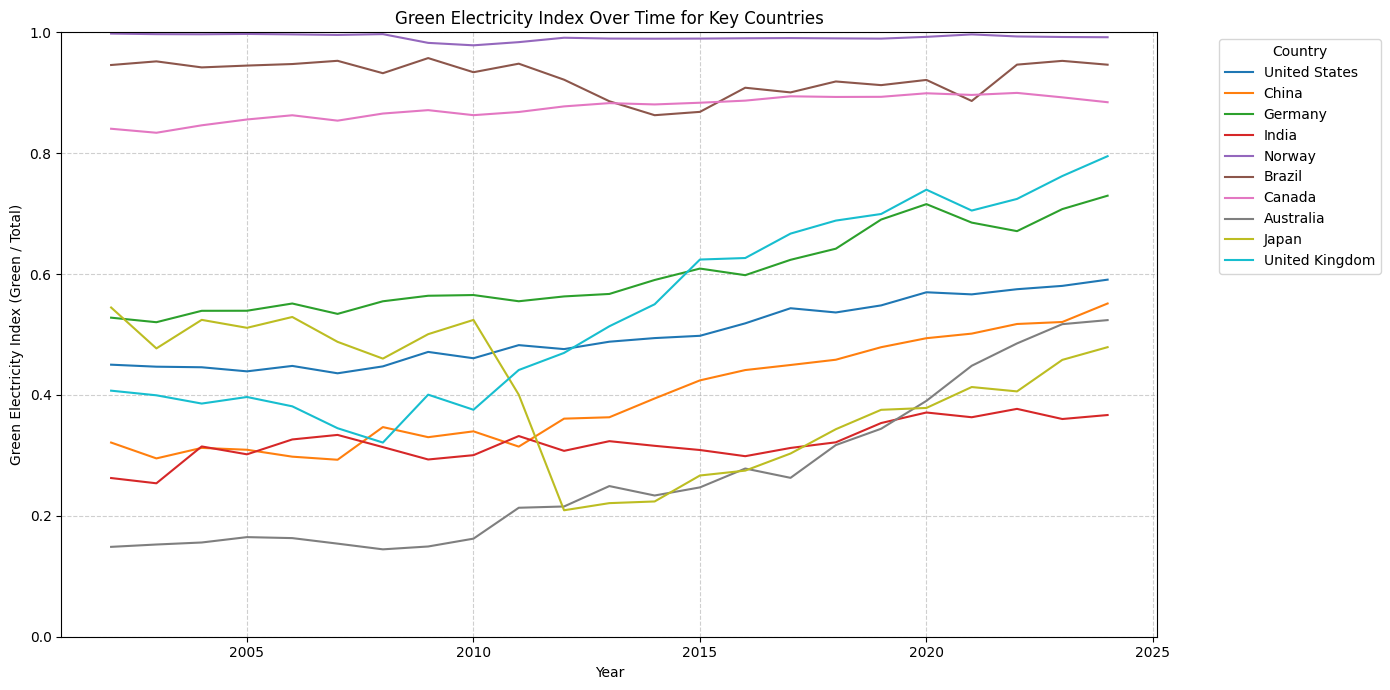

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the energy data
data = pd.read_csv('owid-energy-data.csv')

# 1. Define features and key countries
green_features = ['solar_electricity', 'wind_electricity', 'hydro_electricity',
                  'low_carbon_electricity', 'nuclear_electricity', 'biofuel_electricity',
                  'other_renewable_exc_biofuel_electricity']
fossil_features = ['coal_electricity', 'oil_electricity', 'gas_electricity']
all_electricity_features = green_features + fossil_features

key_countries = ['United States', 'China', 'Germany', 'India', 'Norway',
                 'Brazil', 'Canada', 'Australia', 'Japan', 'United Kingdom']

# 2. Prepare data for calculations
# Filter for key countries and years from 2002 onwards. Select only necessary columns.
filtered_data = data[data['country'].isin(key_countries) & (data['year'] >= 2002)].copy()
filtered_data = filtered_data[['country', 'year'] + all_electricity_features].copy()

# Sort data by country and year for correct time-series imputation
filtered_data.sort_values(by=['country', 'year'], inplace=True)

# 3. Impute missing electricity values
# Fill NaNs using forward-fill then backward-fill within each country's data.
# Finally, fill any remaining NaNs (e.g., entirely missing columns for a country) with 0.
for feature in all_electricity_features:
    filtered_data[feature] = filtered_data.groupby('country')[feature].transform(lambda x: x.ffill().bfill())
filtered_data[all_electricity_features] = filtered_data[all_electricity_features].fillna(0)

# 4. Calculate Green Electricity Index (GEI)
filtered_data['green_electricity_total'] = filtered_data[green_features].sum(axis=1)
filtered_data['fossil_electricity_total'] = filtered_data[fossil_features].sum(axis=1)
filtered_data['total_electricity'] = filtered_data['green_electricity_total'] + filtered_data['fossil_electricity_total']

# Ensure no division by zero: if total electricity is zero, GEI is zero.
filtered_data['green_electricity_index'] = np.where(
    filtered_data['total_electricity'] == 0, 0,
    filtered_data['green_electricity_total'] / filtered_data['total_electricity']
)

# 5. Plot Green Electricity Index over time
plt.figure(figsize=(14, 7))
plotted_countries = [] # To keep track of countries actually plotted

for country in key_countries:
    country_data = filtered_data[filtered_data['country'] == country]
    # Plot if data exists and GEI isn't uniformly zero (meaning some electricity was generated)
    if not country_data.empty and (country_data['green_electricity_index'].nunique() > 1 or country_data['green_electricity_index'].iloc[0] != 0):
        plt.plot(country_data['year'], country_data['green_electricity_index'], label=country)
        plotted_countries.append(country)

plt.title('Green Electricity Index Over Time for Key Countries')
plt.xlabel('Year')
plt.ylabel('Green Electricity Index (Green / Total)')
plt.ylim(0, 1) # GEI is a proportion, so between 0 and 1
plt.grid(True, linestyle='--', alpha=0.6)

# Configure legend
if plotted_countries:
    plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Random forest regression

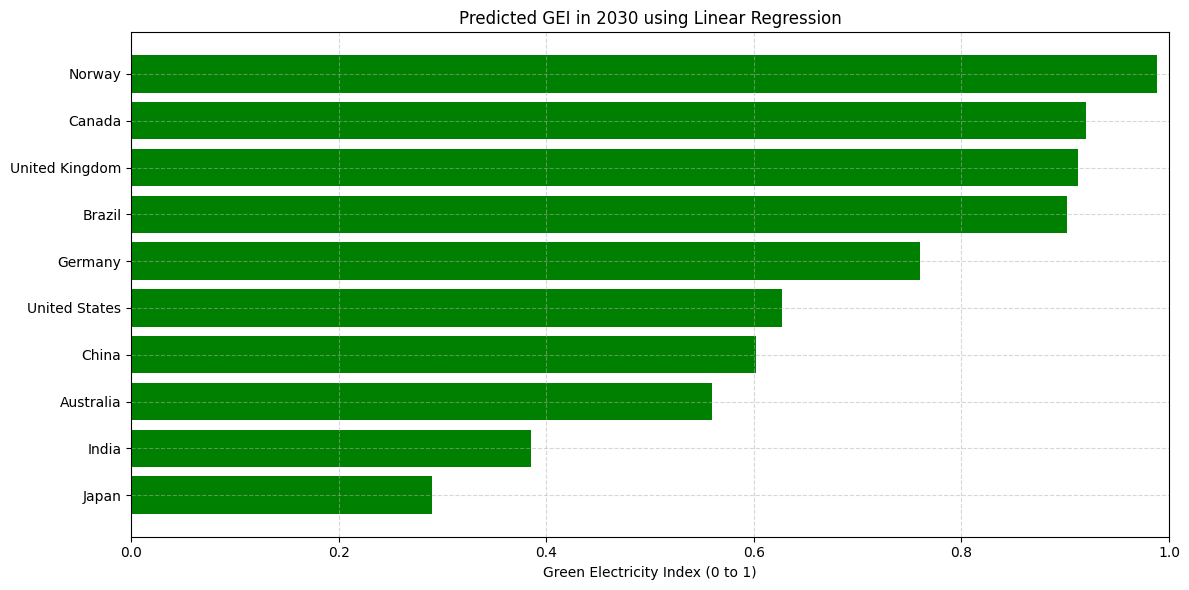

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Placeholder for predictions
predictions_2030 = []

# Loop over countries
for country in key_countries:
    country_data = filtered_data[filtered_data['country'] == country]
    if len(country_data) < 5:
        continue  # not enough data

    X = country_data['year'].values.reshape(-1, 1)
    y = country_data['green_electricity_index'].values

    # Try linear model
    linear_model = LinearRegression()
    linear_model.fit(X, y)
    gei_2030 = linear_model.predict([[2030]])[0]
    predictions_2030.append({'country': country, 'GEI_2030': np.clip(gei_2030, 0, 1)})


results_df = pd.DataFrame(predictions_2030)
results_df.sort_values('GEI_2030', ascending=False, inplace=True)

plt.figure(figsize=(12, 6))
plt.barh(results_df['country'], results_df['GEI_2030'], color='green')
plt.title('Predicted GEI in 2030 using Linear Regression')
plt.xlabel('Green Electricity Index (0 to 1)')
plt.xlim(0, 1)
plt.gca().invert_yaxis()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



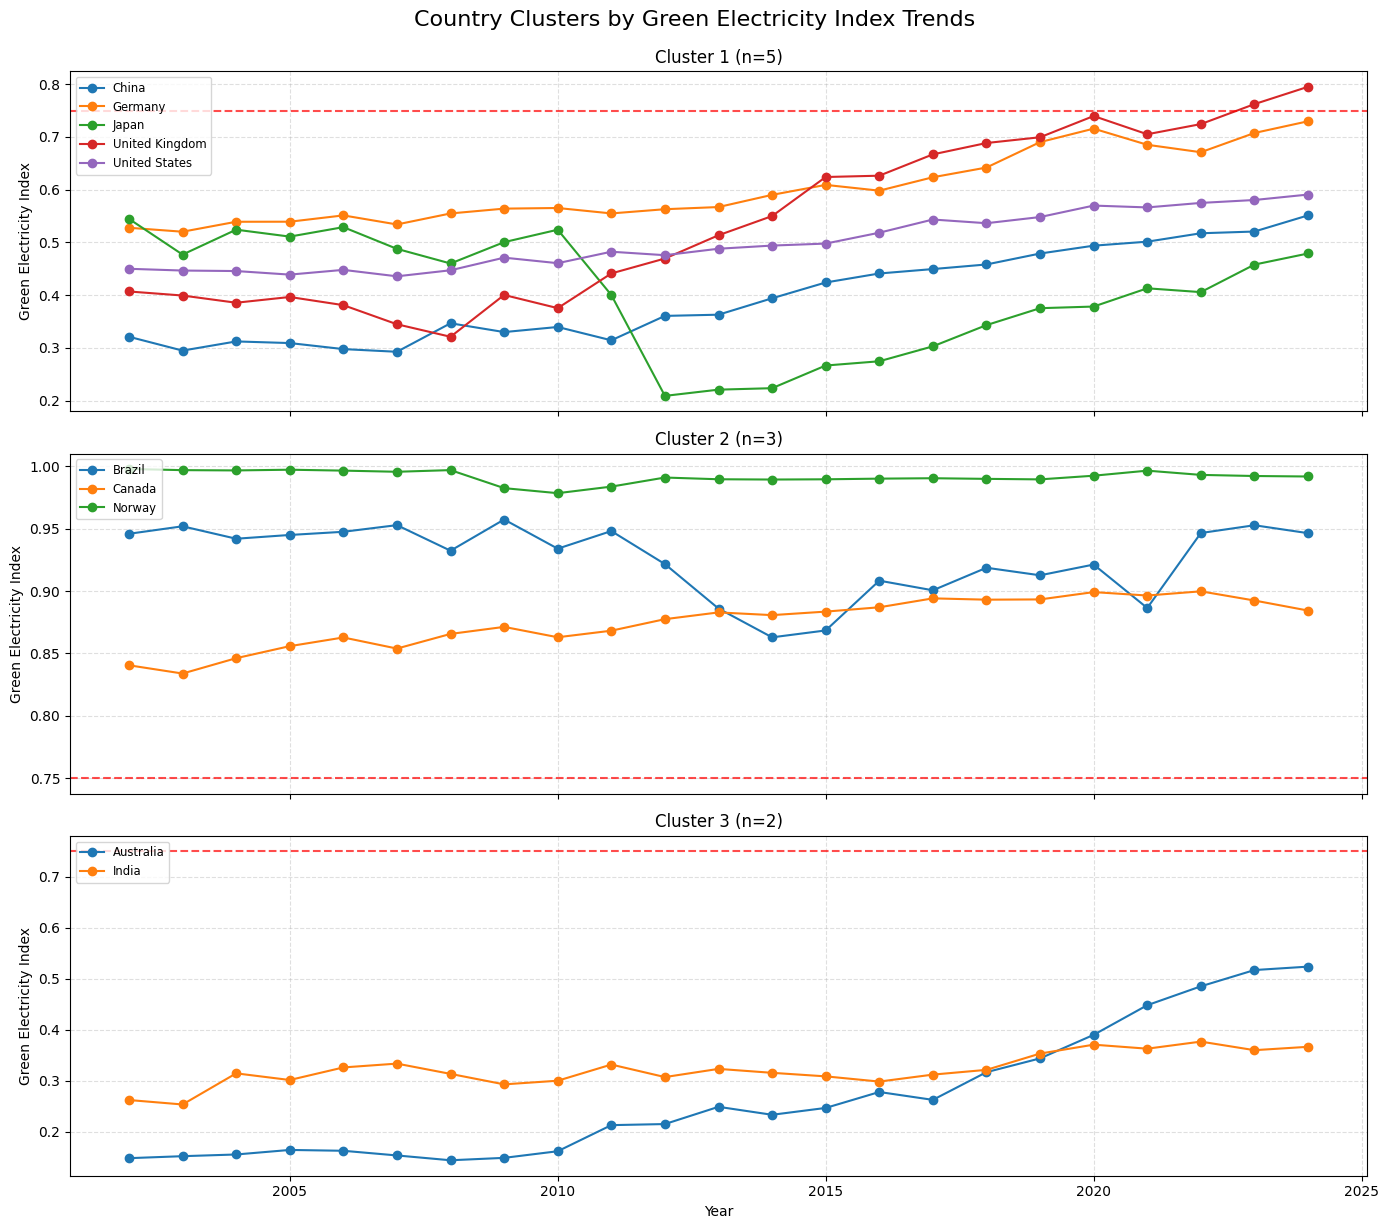

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Prepare GEI Time Series Matrix (country x year) ---
gei_pivot = filtered_data.pivot(index='country', columns='year', values='green_electricity_index')

# Keep only countries with complete data over the years
gei_pivot = gei_pivot.dropna()

# --- 2. Normalize GEI Time Series ---
scaler = StandardScaler()
gei_scaled = scaler.fit_transform(gei_pivot.values)

# --- 3. K-Means Clustering ---
n_clusters = 3  # You can change this to try different cluster counts
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(gei_scaled)

# Add cluster labels back to country index
gei_pivot['cluster'] = clusters

# --- 4. Plot Trends by Cluster ---
years = gei_pivot.columns[:-1]  # Exclude 'cluster' column

fig, axes = plt.subplots(n_clusters, 1, figsize=(14, 4 * n_clusters), sharex=True)

if n_clusters == 1:
    axes = [axes]  # Ensure it's iterable even if only one cluster

for cluster_id in range(n_clusters):
    ax = axes[cluster_id]
    countries_in_cluster = gei_pivot[gei_pivot['cluster'] == cluster_id].index

    for country in countries_in_cluster:
        gei_values = gei_pivot.loc[country, years].values
        ax.plot(years, gei_values, label=country, marker='o')

    ax.set_title(f'Cluster {cluster_id + 1} (n={len(countries_in_cluster)})')
    ax.set_ylabel('Green Electricity Index')
    ax.axhline(0.75, color='red', linestyle='--', alpha=0.7)
    ax.grid(True, linestyle='--', alpha=0.4)
    ax.legend(loc='upper left', fontsize='small')

axes[-1].set_xlabel('Year')
plt.tight_layout()
plt.suptitle('Country Clusters by Green Electricity Index Trends', fontsize=16, y=1.02)
plt.show()


In [ ]:
# Print countries in each cluster
print("\n--- Country Clusters ---")
for cluster_id in range(n_clusters):
    countries = gei_pivot[gei_pivot['cluster'] == cluster_id].index.tolist()
    print(f"Cluster {cluster_id + 1} ({len(countries)} countries):")
    print(", ".join(countries))
    print()

# Calculate average GEI trend per cluster
avg_gei_by_cluster = gei_pivot.groupby('cluster').mean().drop(columns='cluster', errors='ignore')

print("\n--- Average GEI per Cluster (first few years) ---")
print(avg_gei_by_cluster.iloc[:, :5])  # show first few years



--- Country Clusters ---
Cluster 1 (5 countries):
China, Germany, Japan, United Kingdom, United States

Cluster 2 (3 countries):
Brazil, Canada, Norway

Cluster 3 (2 countries):
Australia, India


--- Average GEI per Cluster (first few years) ---
year         2002      2003      2004      2005      2006
cluster                                                  
0        0.450220  0.427732  0.441507  0.439108  0.441501
1        0.928112  0.927598  0.928303  0.932713  0.935644
2        0.205628  0.203210  0.235366  0.233293  0.244785


| Cluster | Countries                     | GEI Start | GEI Trend            | Description                   |
| ------- | ----------------------------- | --------- | -------------------- | ----------------------------- |
| 1       | US, UK, Germany, China, Japan | \~0.45    | Steady increase      | Late-transitioning economies  |
| 2       | Norway, Canada, Brazil        | \~0.93    | Flat/high            | Green electricity pioneers    |
| 3       | India, Australia              | \~0.20    | Low, possibly rising | Fossil-heavy, slow transition |


In [ ]:
from sklearn.linear_model import LinearRegression

# Store results
green_forecast = []

for country in gei_pivot.index:
    gei_series = gei_pivot.loc[country, years].values
    year_array = np.array(years).reshape(-1, 1)

    # Fit linear model
    model = LinearRegression()
    model.fit(year_array, gei_series)

    slope = model.coef_[0]
    intercept = model.intercept_

    # Predict the year when GEI would reach 0.75
    if slope > 0:
        predicted_year = (0.75 - intercept) / slope
        predicted_year = int(np.round(predicted_year))
    else:
        predicted_year = None  # Will never turn green with negative or zero slope

    green_forecast.append({
        'country': country,
        'cluster': gei_pivot.loc[country, 'cluster'],
        'slope': slope,
        'intercept': intercept,
        'predicted_green_year': predicted_year if predicted_year and predicted_year <= 2050 else None
    })

# Create DataFrame
green_forecast_df = pd.DataFrame(green_forecast)

# Show results
print("\n--- Predicted Green Years (GEI ≥ 0.75) ---")
print(green_forecast_df[['country', 'cluster', 'predicted_green_year']].sort_values('predicted_green_year'))

# Identify countries unlikely to turn green
never_green = green_forecast_df[green_forecast_df['predicted_green_year'].isnull()]
if not never_green.empty:
    print("\n--- Countries Unlikely to Turn Green by 2050 ---")
    print(never_green[['country', 'cluster']])



--- Predicted Green Years (GEI ≥ 0.75) ---
          country  cluster  predicted_green_year
2          Canada        1                1966.0
8  United Kingdom        0                2023.0
4         Germany        0                2029.0
0       Australia        2                2041.0
3           China        0                2042.0
9   United States        0                2046.0
1          Brazil        1                   NaN
5           India        2                   NaN
6           Japan        0                   NaN
7          Norway        1                   NaN

--- Countries Unlikely to Turn Green by 2050 ---
  country  cluster
1  Brazil        1
5   India        2
6   Japan        0
7  Norway        1


In [ ]:
most_recent_year = filtered_data['year'].max()
recent_year_data = filtered_data[filtered_data['year'] == most_recent_year]

global_green_total = recent_year_data['green_electricity_total'].sum()
global_fossil_total = recent_year_data['fossil_electricity_total'].sum()
global_total_electricity = global_green_total + global_fossil_total

global_green_index = global_green_total / global_total_electricity

print(f"Global Green Electricity Index ({most_recent_year}): {global_green_index:.4f}")

Global Green Electricity Index (2024): 0.5862
